# SGA: Learning Latent Permutations with Gumbel-Sinkhorn Networks

**Notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/sampling/permutations.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/sampling/permutations.ipynb)  
**Author:**
David Knigge


Code in this tutorial was based on: https://github.com/perrying/gumbel-sinkhorn and https://github.com/google/gumbel_sinkhorn.

## **0. Introduction**
In this notebook, we take a look at implementing a flavour of neural networks that can perform operations on discrete objects. More specifically, we look at **latent permutation**, where the objective is to find the correct **permutation** $P$ of a latent variable without direct supervision. We make use of the **Gumbel-Sinkhorn operator** which allows us to pose the finding of a permutation $P$ as a linear optimization problem. We recommend taking a look at the original paper by [Mena, G., et al., (2018)](https://arxiv.org/abs/1802.08665), though we will briefly introduce all necessary concepts in this notebook.

Questions and feedback may be forwarded to David Knigge; d.m.knigge@uva.nl.



### **0.1 Brief overview of the problem**

Typically, we think of the characteristic of neural networks being flexible enough to learn arbitrarily complex mappings as favourable. However, in many practical applications of neural networks, we can restrict the space of learnable functions by incorporating **inductive biases**; things we a priori know to be true (and relevant) in our problem setting.

An example of the importance of incorporating such inductive biases in model design is in settings where we are performing operations on discrete objects. Think for example of sorting a list of numbers $\mathbf{n}$:

$$
\mathbf{n}^T = \begin{bmatrix}5\\ 1\\ 3\\4\end{bmatrix}
$$

We could obtain a reordering of the numbers by left-multiplying with a permutation matrix $P$;

$$
P = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \end{bmatrix}
$$

Applying such a permutation matrix to our input, we get:

\begin{align}
P \mathbf{n}^T &= \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix}5\\ 1\\ 3\\4\end{bmatrix} \\
&= \begin{bmatrix} 1\\ 3\\4\\5\end{bmatrix}
\end{align}

A natural first instinct would be to let our network learn the permutation matrix $P$ directly. But what if we don't have the ground truth permutation matrix? We may instead optimize our network for the permuted input $P \mathbf{n}^T$.

However, next we should note that the matrix $P$ has some special properties. It is what's known as an instance of a **doubly stochastic matrix**, essentially meaning both its rows and its columns sum to a value of $1$. Each of its rows and columns are one-hot vectors, reflecting the fact that each value in the input $\mathbf{n}^T$ must occur once in the output $P\mathbf{n}^T$, and only at a single location.

How do we get our network do learn to map to such doubly stochastic matrices? This is exactly the focus of the Gumbel-Sinkhorn operator!

Note:
- A permutation matrix is an instance of an orthogonal matrix. Remember that for such matrices, their inverses are given by their transpose. Hence $P^T P = \mathbf{I}$. We use this later on.

### **0.2 Refresher: The Gumbel-Softmax distribution**

The authors introduce the Sinkhorn operator as permutation-friendly analogy to the **Gumbel-Softmax/Concrete** distribution; a differentiable approximation to sampling discrete data. Let's do a quick recap of the Gumbel-Softmax distribution.

Where the reparameterization trick as used in VAE's allows us to differentiably sample from continuous distributions, it is not straightforward to apply this to discrete distributions. 

We can sample from a categorical distribution with class probabilities $\mathbf{\alpha}=[\alpha_1, \alpha_2, \alpha_3]$ using the [Gumbel-Max trick](https://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/), by taking the ${\rm argmax}$ of $\log \alpha + \mathbf{G}$, where $\mathbf{G}=[G_1, G_2, G_3]$~${\rm Gumbel}$. However, since the ${\rm argmax}$ operator isn't differentiable, we can't get gradients from this operation (visualized below in figure $a)$.

Instead, we **relax** the discrete distribution by approximating a sampling from it through the Gumbel-Softmax trick. We replace the ${\rm argmax}$ operation by a softmax with temperature parameter $\lambda$. This operation is differentiable!


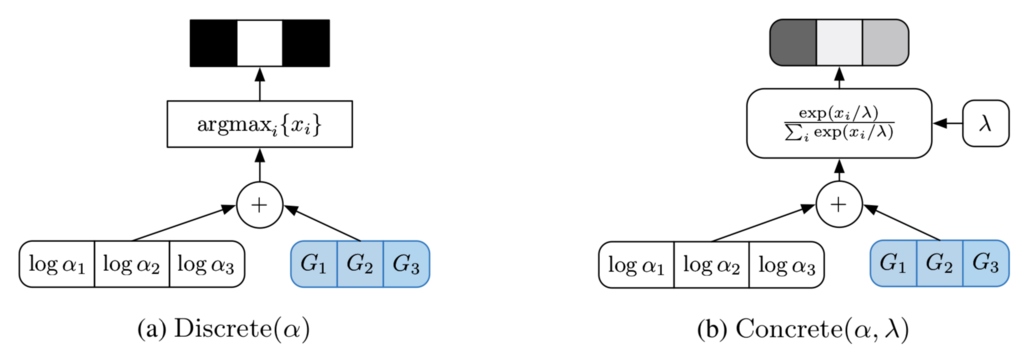

Where $G_i $~$ \text{Gumbel} = -\log(-\log{\rm Unif}(0, 1))$.


### **0.3 Installing and importing some useful packages**

Here we install and import some libraries that we will use throughout this tutorial. We use the `pytorch` as our deep learning framework of choice.

In [1]:
## Standard libraries
import os
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# Download a pretrained model.
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
!wget -O 'saved_models/model.pth' https://raw.githubusercontent.com/david-knigge/uvadlc2-tutorial-Gumbel-Sinkhorn-Networks/main/model.pth

--2022-04-22 12:23:42--  https://raw.githubusercontent.com/david-knigge/uvadlc2-tutorial-Gumbel-Sinkhorn-Networks/main/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31375 (31K) [application/octet-stream]
Saving to: ‘saved_models/model.pth’

100%[======================================>] 31,375      --.-K/s   in 0.001s  

2022-04-22 12:23:42 (39.1 MB/s) - ‘saved_models/model.pth’ saved [31375/31375]



In [3]:
# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## **1. The Gumbel-Sinkhorn operator**


### **1.1 The Gumbel-Sinkhorn operator**
In 0.2, we've seen how we can approximate a discrete distribution with continuous values by a temperature-dependent softmax function;

$$
{\rm softmax}_{\tau}(x_i)=\dfrac{\exp\frac{x_i}{\tau}}{\sum_j \exp\frac{x_j}{\tau}}
$$

If we let the temperature parameter $\tau$ in this softmax approach 0, in the limit we obtain a one-hot vector corresponding to the largest $x_i$. We've found a differentiable way of approaching a categorical distribution! Extending this approximation to use for permutations is the point of the Sinkhorn operator.

The authors define the Sinkhorn operator $S$ as follows:

\begin{align}
S^0(X)&=\exp(X)\\
S^l(X)&= \mathcal{T}_c(\mathcal{T}_r(S^{l-1}(X)))\\
S(X) &= \lim_{l \rightarrow \infty} S^l(X)
\end{align}

Where $\mathcal{T}_c(X) = X \oslash \mathbf{1}_N\mathbf{1}_N^T X$ and $\mathcal{T}_r(X) = X \oslash X\mathbf{1}_N\mathbf{1}_N^T$ with $\oslash$ denoting elementwise division. Essentially, we divide each row value by the sum of its row, and each column value by the sum of its column. Check if you understand these operations. The authors note that, in the limit, $S(X)$ converges to a doubly stochastic matrix! Just the kind we need.

Let's implement the sinkhorn operator!


Notes:
- For numerical stability, the Sinkhorn operator is implemented in the log-space. Remember $\log(\frac{a}{b}) = \log(a) - \log(b)$!
- To ensure positivity, the effective input to sinkhorn has to be
  `exp(log_alpha)` (elementwise). However, note that it is only at return time that entries are exponentiated.
- We make use of the `logsumexp` function to first move $\alpha$ out of the log domain, then sum over $\alpha$ (rows and columns) and then return $\alpha$ to the log domain.

In [4]:
def log_sinkhorn(log_alpha, n_iter):
    """Performs incomplete Sinkhorn normalization to log_alpha.
    By a theorem by Sinkhorn and Knopp [1], a sufficiently well-behaved  matrix
    with positive entries can be turned into a doubly-stochastic matrix
    (i.e. its rows and columns add up to one) via the successive row and column
    normalization.

    [1] Sinkhorn, Richard and Knopp, Paul.
    Concerning nonnegative matrices and doubly stochastic
    matrices. Pacific Journal of Mathematics, 1967
    Args:
      log_alpha: 2D tensor (a matrix of shape [N, N])
        or 3D tensor (a batch of matrices of shape = [batch_size, N, N])
      n_iters: number of sinkhorn iterations (in practice, as little as 20
        iterations are needed to achieve decent convergence for N~100)
    Returns:
      A 3D tensor of close-to-doubly-stochastic matrices (2D tensors are
        converted to 3D tensors with batch_size equals to 1)
    """
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
    return log_alpha.exp()

Let's see whether this function indeed yields a doubly stochastic matrix when we input the log of a matrix of unnormalized probabilities.

In [5]:
# Create a matrix containing random numbers.
X = torch.rand((3, 3))
X

tensor([[0.3834, 0.6550, 0.0086],
        [0.4759, 0.8863, 0.0279],
        [0.5294, 0.4645, 0.8727]])

In [6]:
# Apply the Sinkhorn operator for 20 iterations.
S_X = log_sinkhorn(torch.log(X), n_iter=20)
S_X

tensor([[0.4716, 0.4786, 0.0498],
        [0.4201, 0.4649, 0.1150],
        [0.1083, 0.0565, 0.8352]])

In [7]:
# Check whether rows sum to 1.
assert torch.allclose(S_X.sum(dim=0), torch.ones(S_X.shape[0]))

# Check whether columns sum to 1.
assert torch.allclose(S_X.sum(dim=1), torch.ones(S_X.shape[1]))

### **1.2 Differentiably (deterministically) obtaining a permutation matrix**

#### **1.2.1 The problem with assignment probabilities**
The Sinkhorn operator we defined above is only guaranteed to give us a doubly stochastic matrix $X$ (rows and columns sum to 1) containing assignment probabilities. It is not directly clear how to get from this doubly stochastic matrix $X$ to an actual permutation matrix $P$ (where rows and columns are one-hot vectors). As illustration, given a doubly stochastic matrix $X$:

$$
X = \begin{bmatrix} 0.3 & 0.3 & 0.4 \\ 0.2 & 0.3 & 0.5 \\ 0.5 & 0.4 & 0.1  \end{bmatrix}.
$$

Simply taking the $\arg \max$ of every row would give us:
$$
P = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 0 & 1 \\ 1 & 0 & 0  \end{bmatrix},
$$
Which does not yield a valid permutation matrix.

#### **1.2.2 From assignment probabilities a permutation matrix to as linear assignment problem**

Taking a step back, the authors note that we can frame the assignment of a category $\mathbf{v}_i$ given a set of corresponding assignment probabilities $\mathbf{x}_i$ as a maximization problem. Given a one-hot vector $\mathbf{v}$ and a vector $\mathbf{x}$, we can pick the largest $\mathbf{x}_i$ by choosing $\mathbf{v}$ such that the inner product $\langle\mathbf{x}, \mathbf{v}\rangle$ is maximized.

In similar fashion, the authors note that we can frame the hard choice of a permutation matrix $P$ given a doubly stochastic square matrix $X$ as the solution to the [linear assignment problem](https://en.wikipedia.org/wiki/Assignment_problem). Let $\mathcal{P}_N$ denote the set of all possible permutation matrices $P$ and $\langle A, B \rangle_F$ the Frobenius inner product of matrices given by ${\rm trace} (A^T B)$;

$$
M(X) = \arg\max_{P \in \mathcal{P}_N} \langle P, X \rangle_F
$$

The authors call this operator $M$ the matching function. Intuitively; the best hard choice of permutation matrix $P$ given a doubly stochastic matrix $X$ of assignment probabilities is that $P$ whose inverse most closely maps $X$ to the identity matrix (as this would be the matrix with the largest trace).

We implement code for solving the assignment problem below, using a `scipy` [implementation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html).

Notes:
- Indeed, this way of finding a hard permutation matrix is non-differentiable, so it is of little use to us when training a neural net! We will only use this functionality at test time.
- The `linear_sum_assignment` function expects a cost matrix as input. We instead have a probability matrix, hence we negate the probability matrix before inputting it
- We go from `row` and `col` lists of the indices of our permutation matrix we should set to 1, to a permutation matrix $P$ using [`coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

In [8]:
## Scipy
from scipy.optimize import linear_sum_assignment
from scipy.sparse import coo_matrix


def matching(alpha):
    # Negate the probability matrix to serve as cost matrix. This function 
    # yields two lists, the row and colum indices for all entries in the
    # permutation matrix we should set to 1.
    row, col = linear_sum_assignment(-alpha)

    # Create the permutation matrix.
    permutation_matrix = coo_matrix((np.ones_like(row), (row, col))).toarray()
    return torch.from_numpy(permutation_matrix)

Let's see whether we obtain a hard permutation matrix for the doubly stochastic matrix we created above.

In [9]:
matching(S_X)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

Cool! However, as mentioned above, this way of finding permutation matrices is **deterministic** and **non-differentiable** and hence will not do us much good when training a neural network to parameterize the variable $\alpha$ of a latent distribution.

### **1.3 Sampling a permutation matrix: the Gumbel-Matching distribution**

The authors note that, in order to differentiably sample from a latent distribution such as the distribution of permutation matrices, we would like to apply techniques similar to the reparameterization trick that enable VAE's to learn. However, our latent distribution is discrete.

To set the stage, the authors recall the intuition behind the Gumbel-Softmax distribution; (1) with the Gumbel-max trick, we are able to sample from a categorical distribution but (2) since this reparameterization is non-differentiable (as we saw before) we instead relax the Gumbel distribution using the softmax operation, and thus obtain the Gumbel-Softmax distribution. 

The authors introduce the Gumbel-Matching distribution $\mathcal{G}.\mathcal{M}.$, the distribution of permutation matrices we get when applying i.i.d. Gumbel noise to each of the entries of an assignment probability matrix $X$.

$$
M(X+\epsilon)\text{ ~ } \mathcal{G}.\mathcal{M}., \text{with }\epsilon \text{ ~ } \text{Gumbel}
$$

As in the categorical case, sampling from this distribution is still not differentiable however, as it still requires us to find the solution to a linear assignment problem. 

### **1.3 Gumbel-Sinkhorn: Continuous relaxation of the Gumbel-Matching distribution**

Now we come to the main theoretical contribution of the paper. The authors first show that the solution to the matching function $M(X)$ can in fact be obtained as the limit of the Sinkhorn operator $S(\frac{X}{\tau})$ with a small value of $\tau$. 

Finally, the authors introduce the Gumbel-Sinkhorn distribution $\mathcal{G}.\mathcal{S}.$ as the distribution obtained by applying the Sinkhorn operator on an unnormalized assignment probability matrix to which we add i.i.d. Gumbel noise:

$$
S(\frac{X + \epsilon}{\tau}) \text{ ~ } \mathcal{G}.\mathcal{S}., \text{with }\epsilon \text{ ~ } \text{Gumbel}.
$$

The authors show that in the limit, samples from the Gumbel-Sinkhorn distribution almost surely converge to the Gumbel-Matching distribution. The Sinkhorn operator is differentiable and may serve as a continuous relaxation for $M(X)$, allowing us to backpropagate through it!

For proof of this finding, we kindly refer you to appendix A of the [paper](https://arxiv.org/abs/1802.08665).

Let's implement the Gumbel-Sinkhorn distribution!

In [10]:
def sample_gumbel(shape, device='cpu', eps=1e-20):
    """Samples arbitrary-shaped standard gumbel variables.
    Args:
      shape: list of integers
      eps: float, for numerical stability
    Returns:
      A sample of standard Gumbel random variables
    """
    u = torch.rand(shape, device=device)
    return -torch.log(-torch.log(u + eps) + eps)

Let's sample some Gumbel noise.

In [11]:
sample_gumbel((3, 3))

tensor([[ 0.1238,  0.9551, -0.6666],
        [ 1.1801, -0.8376, -0.1454],
        [-0.9623,  3.0603,  0.2785]])

In [12]:
def gumbel_sinkhorn(log_alpha, tau, n_iter):
    """ Sample a permutation matrix from the Gumbel-Sinkhorn distribution
    with parameters given by log_alpha and temperature tau.

    Args:
      log_alpha: Logarithm of assignment probabilities. In our case this is
        of dimensionality [num_pieces, num_pieces].
      tau: Temperature parameter, the lower the value for tau the more closely
        we follow a categorical sampling.
    """
    # Sample Gumbel noise.
    gumbel_noise = sample_gumbel(log_alpha.shape, device=log_alpha.device)

    # Apply the Sinkhorn operator!
    sampled_perm_mat = log_sinkhorn((log_alpha + gumbel_noise)/tau, n_iter)
    return sampled_perm_mat

Let's sample some permutation matrices.

In [13]:
# For low values of tau the sampled matrices are closer to actual
# permutation matrices.
gumbel_sinkhorn(X, tau=0.01, n_iter=20)

tensor([[1.0931e-15, 1.0000e+00, 1.6772e-38],
        [0.0000e+00, 2.3445e-10, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00]])

In [14]:
# For higher values of tau the sampled matrices are 'less categorical'
gumbel_sinkhorn(X, tau=10, n_iter=20)

tensor([[0.3739, 0.3147, 0.3113],
        [0.3008, 0.3512, 0.3480],
        [0.3252, 0.3341, 0.3407]])

Importantly, this operation is differentiable!

In [15]:
# Create a matrix containing random numbers. Let PyTorch know we want gradients.
X = torch.rand((3, 3), requires_grad=True)

# Sample a permutation matrix from the Gumbel-Sinkhorn distribution.
P = gumbel_sinkhorn(X*1000, tau=1, n_iter=2000)
P.sum().backward()

X.grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2052e-11, -1.2052e-11,  3.0366e-38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

## **2. Implementing a Sinkhorn Network for learning latent permutations**

We now have everything in place to build our own Sinkhorn network! We will be solving the task of unscrambling MNIST digits. First, let's implement the network.

### **2.1 Sinkhorn Convolutional Network**

We replicate the convolution-based Sinkhorn network that the authors visualize in figure 1 (see below).

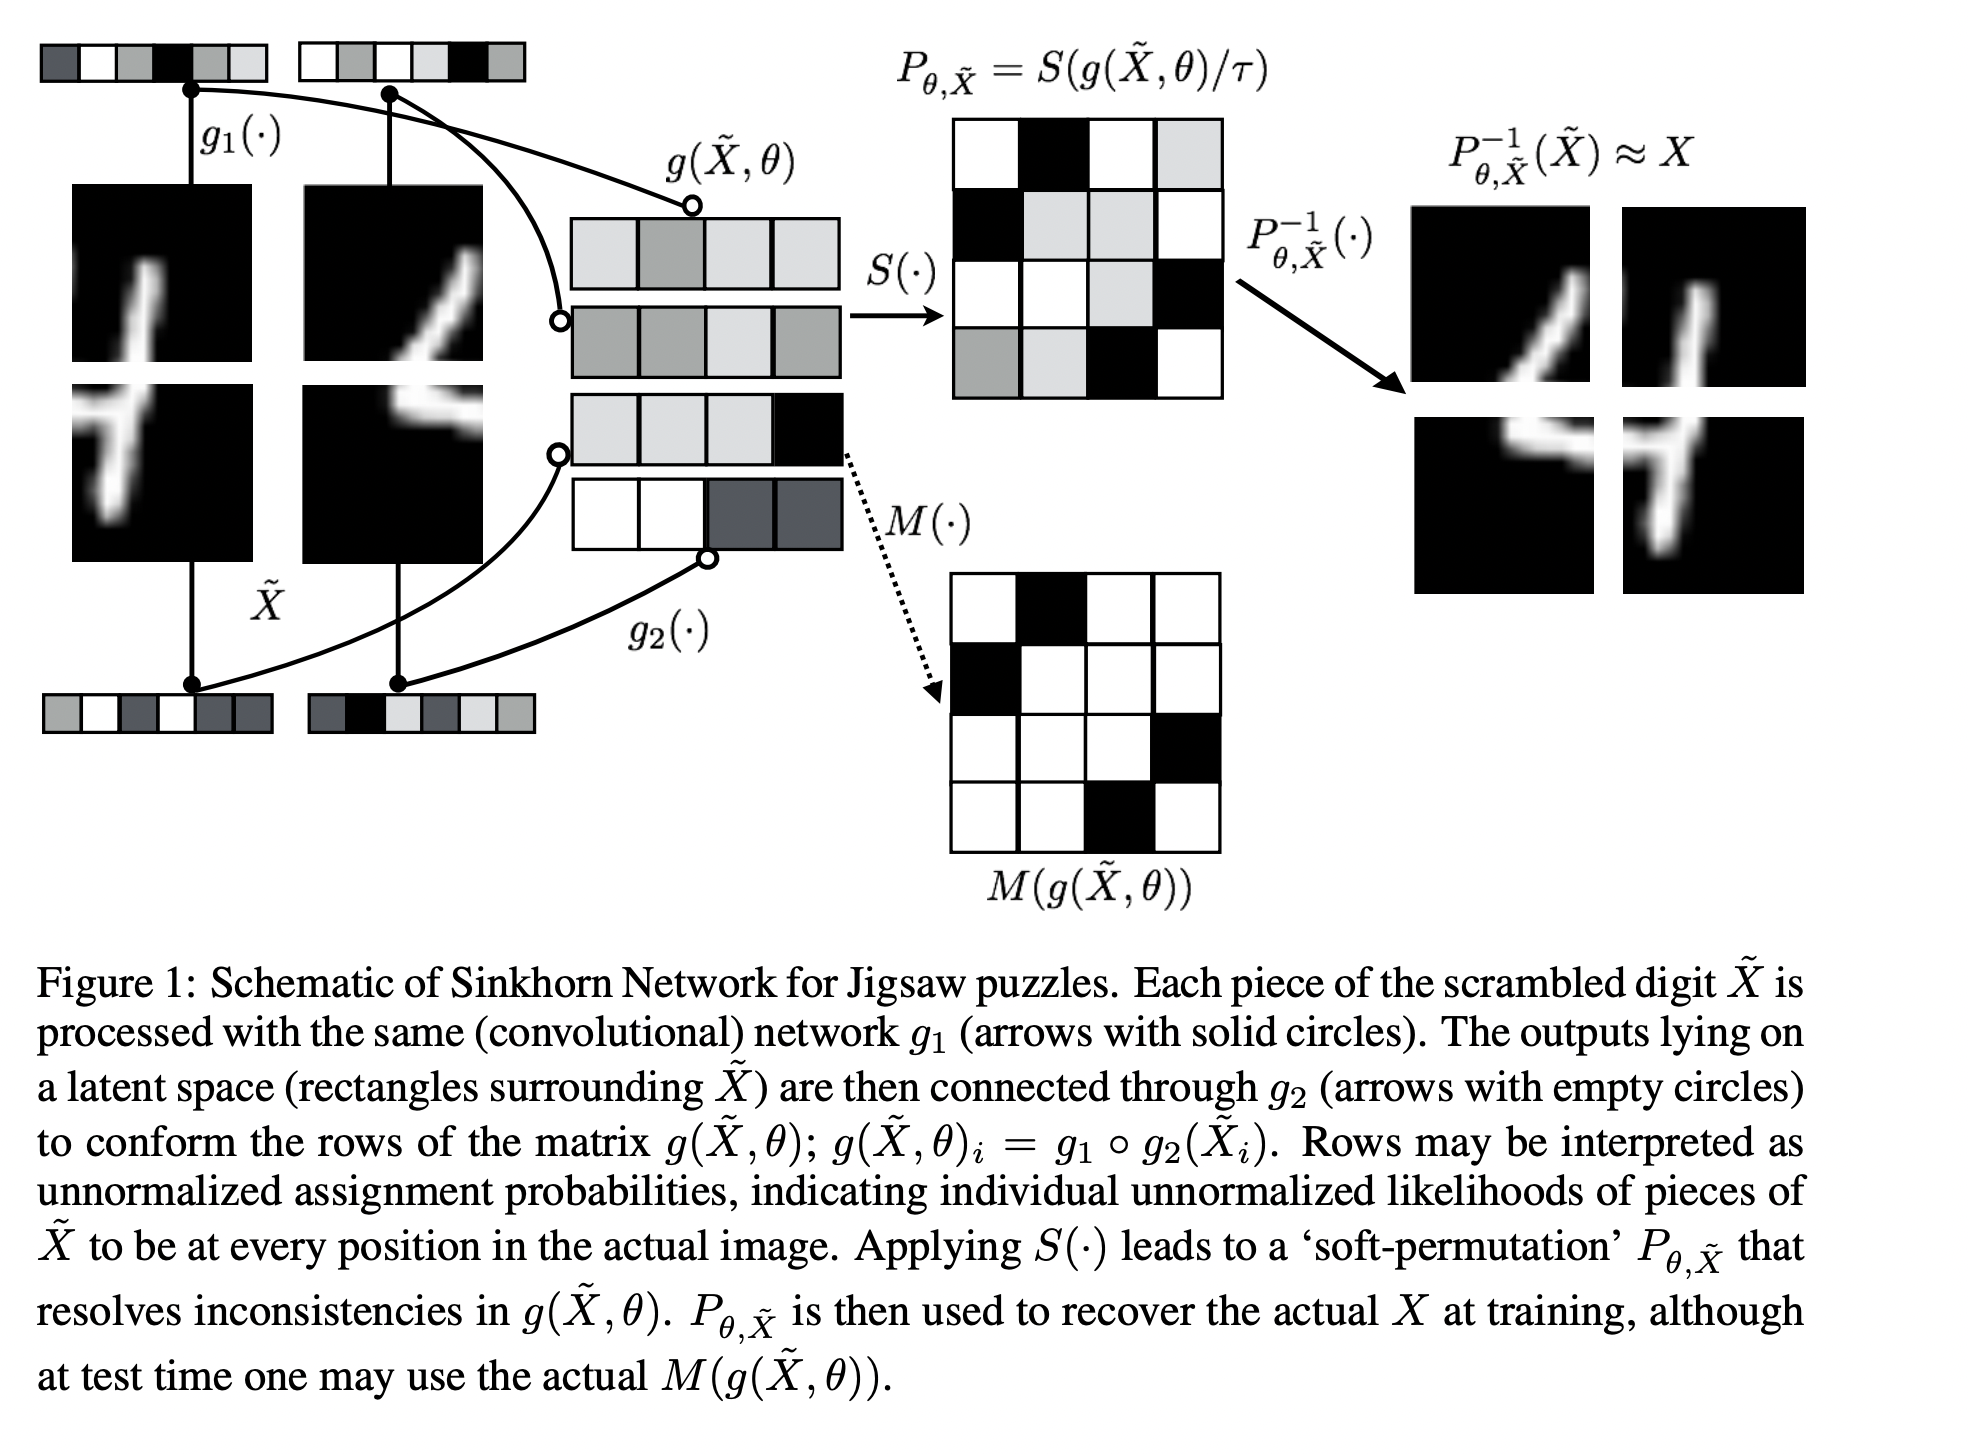

In [16]:
import torch
import torch.nn as nn

class SinkhornConvNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_pieces: int,
        image_size: int,
        hidden_channels: int,
        kernel_size: int,
        tau: float = 1.0,
        n_sink_iter: int = 20,
    ):
        super().__init__()

        # store these for later use.
        self.tau = tau
        self.n_sink_iter = n_sink_iter

        self.g_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size, padding=kernel_size//2),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(hidden_channels)
        )

        # calculate the size of a single piece in pixels
        piece_size = image_size // num_pieces

        # calculate the size of a single piece in pixels after 1 max pooling
        piece_size_after_conv = (piece_size) // (2 * 1)

        self.g_2 = nn.Linear(piece_size_after_conv**2 * hidden_channels, num_pieces**2, bias=False)

    def forward(self, batch_pieces):
        batch_size = batch_pieces.shape[0]
        
        # Switch batch and piece dimensions. We want to apply the same network
        # to each of the pieces.
        pieces = batch_pieces.transpose(0, 1).contiguous()

        # Apply g_1 to each of the pieces.
        conv_pieces = []
        for piece in pieces:
            piece = self.g_1(piece)
            conv_piece = piece.reshape(batch_size, -1)
            conv_pieces.append(conv_piece)

        # Apply g_2 to each of the pieces.
        latent_pieces = []
        for piece in conv_pieces:
            latent_piece = self.g_2(piece)
            latent_pieces.append(latent_piece)

        # Create a matrix of log unnormalized assignment probabilities. After this
        # the batch dimension is batch in the first position.
        log_alphas = torch.stack(latent_pieces, 1)

        # During training, we sample from the Gumbel-Sinkhorn distribution.
        if self.training:
            permutation_matrices = gumbel_sinkhorn(log_alphas, tau=self.tau, n_iter=self.n_sink_iter)
        
        # During eval, we solve the linear assignment problem.
        else:
            permutation_matrices = torch.stack([
                matching(log_alpha) 
                for log_alpha in log_alphas.cpu().detach().numpy()]
            ).float().to(log_alphas.device)

        # We obtain the ordered pieces as predicted by our network
        ordered_pieces = inverse_permutation_for_image(batch_pieces, permutation_matrices)

        # Return the ordered pieces, along with the predicted permutation.
        # We will inspect the predicted permutation matrices during test time.
        return ordered_pieces, permutation_matrices


### **2.2 Unscrambling MNIST digits**

#### **2.2.1 Scrambling MNIST.**

First, we will define some utility functions for chunking and scrambling the images.

In [17]:
def chunk_image(image: torch.Tensor, num_pieces: int):
    """Randomly chunk a single image.
    Args:
      image: Image [channels, height, width].
    
    Returns:
      pieces: Image chunks in their original positions. [num_pieces, channels,
        height // num_pieces, width // num_pieces]
      random_pieces: Image chunks in their randomly permuted positions.
      permute_index: List of permuted indices.
    """
    # Get image dimensions.
    height, width = image.shape[-2:]
    
    # Get piece dimensions.
    piece_height = height // num_pieces
    piece_width  = width // num_pieces
    pieces = []

    # Obtain indices for each of the image chunks.
    for p_h in range(num_pieces):
        for p_w in range(num_pieces):
            left   = p_w * piece_width
            right  = left + piece_width
            top    = p_h * piece_height
            bottom = top + piece_height
            piece  = image[:,top:bottom,left:right]
            pieces.append(piece)
    
    pieces = torch.stack(pieces, 0)

    # Randomly permute the index of the pieces.
    permute_index = torch.randperm(num_pieces**2)
    random_pieces = pieces[permute_index]
    return pieces, random_pieces, permute_index

def batch_chunk_image(images: torch.Tensor, num_pieces: int):
    """Randomly chunk a batch of images.
    Args:
      image: Images [batch, channels, height, width].
    
    Returns:
      pieces: Batch of image chunks in their original positions. [batch, 
        num_pieces, channels, height // num_pieces, width // num_pieces]
      random_pieces: Batch of image chunks in their randomly permuted positions.
         [batch, num_pieces, channels, height // num_pieces, width // num_pieces]
      permute_index: Batch of permutation lists. [batch, num_pieces**2]
    """
    batch_pieces, batch_random_pieces, batch_permute_index = [], [], []
    for image in images:
        pieces, random_pieces, permute_index = chunk_image(image, num_pieces)
        
        batch_pieces.append(pieces)
        batch_random_pieces.append(random_pieces)
        batch_permute_index.append(permute_index)
    return torch.stack(batch_pieces, 0), torch.stack(batch_random_pieces, 0), torch.stack(batch_permute_index, 0)


def inverse_permutation_for_image(X, permutation_matrix):
    """Apply the inverse of a permutation (its transpose) to a batch of image
       chunks.
    Args:
      X: Batched sets of image chunks. [batch, num_pieces, channels, height, width]
      permutation_matrix: float, for numerical stability
    
    Returns:
      Permuted set of image chunks.
    """
    return torch.einsum("bpq,bpchw->bqchw", (permutation_matrix, X)).contiguous()

Let's load the MNIST dataset and have a look.

In [18]:
from torchvision import datasets
from torchvision import transforms

from torch import optim
from torch.utils.data import DataLoader

device = torch.device('cuda')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(trainset, 64, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, 64, drop_last=False, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


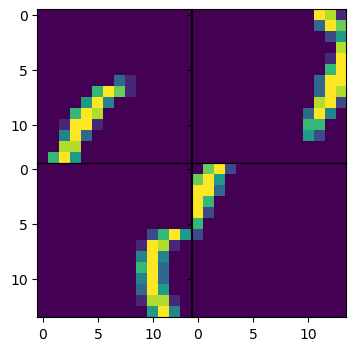

In [19]:
image_batch, _ = next(iter(test_loader))

# Chunk the images into 2 pieces
num_pieces = 2

# Select an image from the batch
batch_idx = 0

pieces, random_pieces, perm_list = batch_chunk_image(image_batch, num_pieces=num_pieces)
pieces, random_pieces = pieces.to(device), random_pieces.to(device)

# Plot the original scrambed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4,4), sharex=True, sharey=True)
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#### **2.2.2 Training the model**

Let's set the hyperparameters for our model.

In [20]:
tau = 0.1 # Temperature parameter.
n_sink_iter = 20 # Number of iterations of Sinkhorn operator.

num_pieces = 2 # Number of pieces each side.
image_size = 28 # Original image size.

in_channels = 1
hidden_channels = 32
kernel_size = 5

epochs = 5
learning_rate = 1e-4
train = False # Set this to false if you only want to evaluate the model

In [21]:
model = SinkhornConvNet(
    in_channels=in_channels,
    num_pieces=num_pieces,
    image_size=image_size,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    tau=tau,
    n_sink_iter=n_sink_iter
).to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, eps=1e-8)

Next, we train the model. With a small number of pieces, after 5 epochs the network already obtains remarkable accuracy.

In [22]:
if train:
    model.train()
    for epoch in range(epochs):
        sum_loss = 0
        for i, data in enumerate(train_loader):
            inputs, _ = data

            # Chunk the images into pieces
            pieces, random_pieces, _ = batch_chunk_image(inputs, num_pieces)
            pieces, random_pieces = pieces.to(device), random_pieces.to(device)

            # Predict the ordering of the pieces using the Sinkhorn Network
            ordered_pieces, _ = model(random_pieces)

            # Apply MSE Loss
            loss = torch.nn.functional.mse_loss(ordered_pieces, pieces, reduction='sum')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            
        print(f"epoch {epoch}|  mean loss {round(sum_loss/len(train_loader.dataset), 4)}")
    
    if not os.path.exists('./saved_models/'):
        os.mkdir('./saved_models')
    torch.save(model.state_dict(), "./saved_models/model.pth")

#### **2.2.2 Evaluating the networks predictions.**

To evaluate the network's predicted permutation matrices, we follow the authors in using the Kendall-Tau correlation coefficient. We measure how correlated the predicted list of permutation indices is to the original list of permutation indices.

In [23]:
# Scipy
from scipy.stats import kendalltau

model = SinkhornConvNet(
    in_channels=in_channels,
    num_pieces=num_pieces,
    image_size=image_size,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    tau=tau,
    n_sink_iter=n_sink_iter
).to(device)

model.load_state_dict(torch.load(os.path.join("./saved_models/model.pth")))
model = model.to(device)
model.eval()

with torch.no_grad():

    kendall_taus = []

    for data in test_loader:
        inputs, _ = data
        pieces, random_pieces, perm_list = batch_chunk_image(inputs, num_pieces)
        pieces, random_pieces = pieces.to(device), random_pieces.to(device)

        ordered_pieces, predicted_permutation_matrices = model(random_pieces)

        # Create the list of inverse permutation indices from the predicted
        # permutation matrix.
        predicted_perm_list = predicted_permutation_matrices.transpose(1, 2).max(1)[1]

        # Obtain the Kendall-Tau correlation coefficient for the target
        # and predicted list of permutation matrices.
        for p1, p2 in zip(perm_list, predicted_perm_list):
            kendall_taus.append(
                kendalltau(p1.cpu(), p2.cpu())[0]
            )

    print(f"Mean Kendall-Tau: {np.mean(kendall_taus)}")

/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Mean Kendall-Tau: 0.9930666666666667


For small numbers of pieces, the correlation coefficient is close to 1! This means our Sinkhorn network is able to correctly find the correct permutation in almost all cases.

Finally, let's inspect model predictions!

In [24]:
image_batch, _ = next(iter(test_loader))
pieces, random_pieces, perm_list = batch_chunk_image(image_batch, num_pieces)
pieces, random_pieces = pieces.to(device), random_pieces.to(device)

# Make sure we are evaluating!
model.eval()

# Predict the correctly ordered pieces.
predicted_pieces, _ = model(random_pieces)

In [25]:
# Select an image from the batch.
batch_idx = 3

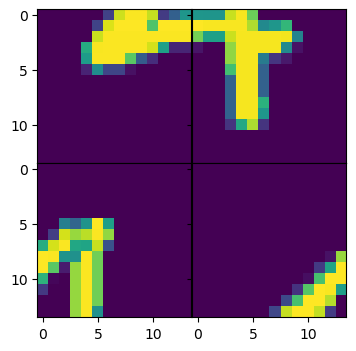

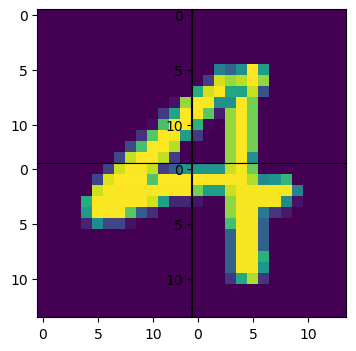

In [26]:
# Plot the original scrambed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4,4), sharex=True, sharey=True)
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Plot the predicted reconstructed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4,4))
for idx, piece in enumerate(predicted_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()